<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/alpha_RNN_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# alpha-RNN insights notebook
# Author: Matthew Dixon
# Version: 1.0 (1.1.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 
# Description: The purpose of this notebook is to (i) illustrate the response of alpha-RNN to unit shocks; and (ii) visualize its PACF structure.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [0]:
x=[1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0] # data

p = 3 # memory
w = 1 # weight
u = 1 # recurrence weight
b = 0 # bias

In [0]:
def sigma(x):
    """
    Define the activation function as tanh
    """
    return np.tanh(x)

In [0]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

In [0]:
def heaviside(x):
    if x>=0:
        return 1
    else:
        return 0

In [0]:
def alphaRNN(x, plain=False, fixed_alpha=False, alpha=1.0):
    """
    x: is the univariate data
    plain: is a boolean indicating whether to simulate plain RNN or alpha-RNN
    fixed_alpha: is a boolean indicating whether alpha should be dynamic or static (fixed)
    alpha: the default value of alpha (ignored if fixed_alpha=False)
    """
    output=np.array([0]*len(x), dtype='float32')
    alpha_hat_ar=np.array([0]*len(x), dtype='float32')
    h_tilde = 0 
    alpha_hat = 1
    if fixed_alpha:
        alpha_hat=alpha
    for i in range(len(x)):
        #if plain:
        h_hat=0 # there is no recurrent step at the last lag: h_hat=sigma(w*x[i-p+j] + b)
        for j in range(p):
            if (i-p+j)>=0:
                #h_hat=sigma(w*x[i-p+j] + u*h_tilde + b)
                if not plain:
                    if not fixed_alpha:
                      alpha_hat=sigmoid(w*x[i-p+j] + u*h_tilde + b)    
                    h_tilde = (1-alpha_hat)*h_tilde + alpha_hat*h_hat
                else:
                    h_tilde=h_hat
                h_hat=sigma(w*x[i-p+j] + u*h_tilde + b)    
            
        output[i]=h_tilde
        alpha_hat_ar[i]=alpha_hat
        
    return(output, alpha_hat_ar)    

In [0]:
plain_RNN,alpha_hat_ar=alphaRNN(x, True) # plain RNN
alpha_RNN,alpha_hat_ar=alphaRNN(x, False, True, alpha=0.5) #fixed alpha-RNN
alpha_t_RNN, alpha_hat_ar=alphaRNN(x) #  dynamic alpha_t-RNN

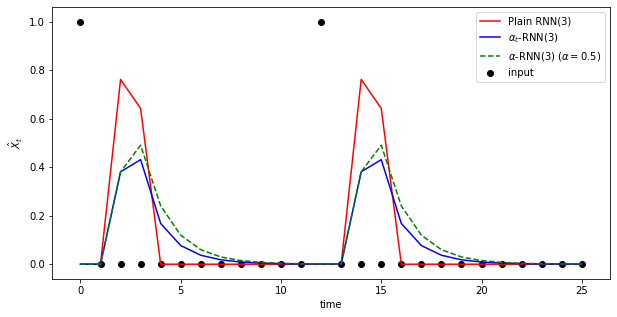

In [84]:
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), plain_RNN, color='red', label='Plain RNN(3)')
plt.plot(range(len(x)), alpha_t_RNN, color='blue', label='$\\alpha_t$-RNN(3)')
plt.plot(range(len(x)), alpha_RNN, color='green', linestyle='--', label='$\\alpha$-RNN(3) ($\\alpha=0.5$)')

plt.scatter(range(len(x)),x, color='black', label='input')
plt.xlabel('time')
plt.ylabel('$\hat{X}_t$')
plt.legend()

Text(0, 0.5, '$\\hat{\\alpha}_t$')

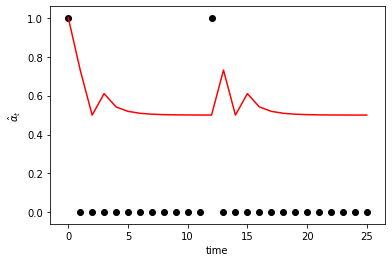

In [85]:
plt.plot(range(len(x)), alpha_hat_ar, color='red', label='Plain RNN(3)')
plt.scatter(range(len(x)),x, color='black', label='input')
plt.xlabel('time')
plt.ylabel('$\\hat{\\alpha}_t$')

# Simulate the PACF

In this section, we simulate the data under different models and compare their estimated PACFs

In [0]:
def simulateAlphaRNN(p, n, plain=False, fixed_alpha=False, alpha=1.0):
    """
    p: is the order of the model
    n: is the length of the simulated data
    plain: is a boolean indicating whether to simulate plain RNN or alpha-RNN
    fixed_alpha: is a boolean indicating whether alpha should be dynamic or static (fixed)
    alpha: the default value of alpha (ignored if fixed_alpha=False)
    """
    
    x = np.array([0]*n, dtype='float32')
    x[:p]= 1 # initialize the first p values
    alpha_hat_ar=np.array([0]*n, dtype='float32')
    h_tilde = 0 
    alpha_hat = 0
    if fixed_alpha:
        alpha_hat=alpha
    for i in range(n):
        if plain:
            h_tilde = 0 # there is no recurrent step at the last lag: h_hat=sigma(w*x[i-p+j] + b)
        for j in range(p):
            if (i-p+j)>=0:
                h_hat=np.tanh(w*x[i-p+j] + u*h_tilde + b)
                if not plain:
                    if not fixed_alpha:
                      alpha_hat=sigmoid(w*x[i-p+j] + u*h_tilde + b)
                    h_tilde = (1-alpha_hat)*h_tilde + alpha_hat*h_hat
                else:
                    h_tilde=h_hat
            
        x[i]=h_tilde + np.random.randn()
        alpha_hat_ar[i]=alpha_hat
        
    return(x, alpha_hat_ar)   

In [0]:
x_RNN,alpha_hat_ar=simulateAlphaRNN(3,10000, True) # plain RNN
x_alpha_RNN,alpha_hat_ar=simulateAlphaRNN(3,10000, False, True, alpha=0.1) #fixed alpha-RNN
x_alpha_t_RNN, alpha_hat_ar=simulateAlphaRNN(3,10000) #  dynamic alpha_t-RNN

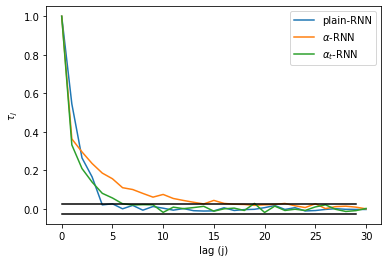

In [21]:
pacf=sm.tsa.stattools.pacf(x_RNN, nlags=30)
alpha_pacf=sm.tsa.stattools.pacf(x_alpha_RNN, nlags=30)
alpha_t_pacf=sm.tsa.stattools.pacf(x_alpha_t_RNN, nlags=30)

plt.plot(pacf, label='plain-RNN')
plt.plot(alpha_pacf, label='$\\alpha$-RNN')
plt.plot(alpha_t_pacf, label='$\\alpha_t$-RNN')
plt.plot([2.58/np.sqrt(len(x_RNN))]*30, color='black')
plt.plot([-2.58/np.sqrt(len(x_RNN))]*30, color='black')
plt.xlabel('lag (j)')
plt.ylabel('$\\tau_j$')
#plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (upper)')
#plt.plot([-2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (lower)')
plt.legend()

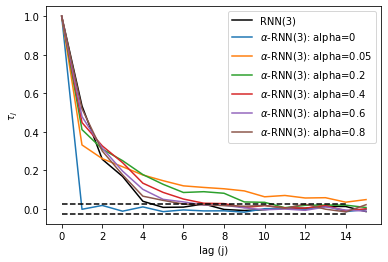

In [52]:
x_RNN,alpha_hat_ar=simulateAlphaRNN(3,10000, True) # plain RNN
pacf=sm.tsa.stattools.pacf(x_RNN, nlags=15)
plt.plot(pacf, label='RNN(3)', color='black')

x_alpha_RNN,_ =simulateAlphaRNN(3,10000, False, True, alpha=0)
pacf=sm.tsa.stattools.pacf(x_alpha_RNN, nlags=15)
plt.plot(pacf, label='$\\alpha$-RNN(3): alpha=' + str(round(0,2)))


x_alpha_RNN,_ =simulateAlphaRNN(3,10000, False, True, alpha=0.05)
pacf=sm.tsa.stattools.pacf(x_alpha_RNN, nlags=15)
plt.plot(pacf, label='$\\alpha$-RNN(3): alpha=' + str(round(0.05,2)))


alpha_pacf=[]
x_alpha_RNN = []
for alpha in np.arange(0.2,1,0.2):
  x_alpha_RNN.append(simulateAlphaRNN(3,10000, False, True, alpha=alpha)[0]) #fixed alpha-RNN
  alpha_pacf.append(sm.tsa.stattools.pacf(x_alpha_RNN[-1], nlags=15))
  plt.plot(alpha_pacf[-1], label='$\\alpha$-RNN(3): alpha=' + str(round(alpha,2)))

plt.xlabel('lag (j)')
plt.ylabel('$\\tau_j$')
plt.legend()  
plt.plot([2.58/np.sqrt(10000)]*15, label='99% confidence interval (upper)', color='black', linestyle='--')
plt.plot([-2.58/np.sqrt(10000)]*15, label='99% confidence interval (lower)',color='black',linestyle='--')


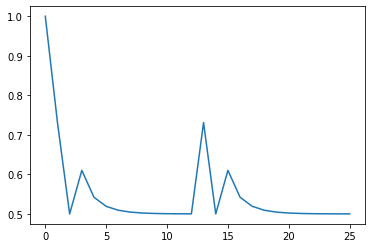

In [86]:
plt.plot(alpha_hat_ar)

### Regime switching dataset

In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift) 

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
w_h,w_alpha = [1, 1] # weight
u_h1,u_h2,u_alpha =[1.5422446 , 0.1, 0.26787302]
b_h,b_alpha=[0,  -0.2]
wy=-0.668827
by=0.12317848
#[array([[-2.1030974, -1.1191764]], dtype=float32), array([[1.5422446 , 0.26787302]], dtype=float32), array([[-2.3388352 ,  0.10435292],
#       [-2.3456423 ,  0.03589532]], dtype=float32)]
#[array([[-0.668827]], dtype=float32), array([0.12317848], dtype=float32)]

In [0]:
def alphaRNN_switching(x, plain=False, fixed_alpha=False, alpha=1.0):
    """
    x: is the univariate data
    plain: is a boolean indicating whether to simulate plain RNN or alpha-RNN
    fixed_alpha: is a boolean indicating whether alpha should be dynamic or static (fixed)
    alpha: the default value of alpha (ignored if fixed_alpha=False)
    """
    output=np.array([0]*len(x), dtype='float32')
    alpha_hat_ar=np.array([0]*len(x), dtype='float32')
    s_ar=np.array([0]*len(x), dtype='float32')
    h_tilde = 0 
    alpha_hat = 1
    s=0
    if fixed_alpha:
        alpha_hat=alpha
    for i in range(len(x)):
        #if plain:
        h_hat=0 # there is no recurrent step at the last lag: h_hat=sigma(w*x[i-p+j] + b)
        for j in range(p):
            if (i-p+j)>=0:
                #h_hat=sigma(w*x[i-p+j] + u*h_tilde + b)
                if not plain:
                    if not fixed_alpha:
                      alpha_hat=sigmoid(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha)    
                    h_tilde = (1-alpha_hat)*h_tilde + alpha_hat*h_hat
                else:
                    h_tilde=h_hat
                s=sigmoid(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha)
                h_hat=sigma(w_h*x[i-p+j] + (s*u_h1+(1-s)*u_h2)*h_tilde + b_h)    
        
        output[i]=h_tilde
        alpha_hat_ar[i]=alpha_hat
        s_ar[i] = s
        
    return(output, alpha_hat_ar,s_ar)    

In [0]:
def simulateAlphaRNN(p, n, plain=False, fixed_alpha=False, alpha=1.0):
    """
    p: is the order of the model
    n: is the length of the simulated data
    plain: is a boolean indicating whether to simulate plain RNN or alpha-RNN
    fixed_alpha: is a boolean indicating whether alpha should be dynamic or static (fixed)
    alpha: the default value of alpha (ignored if fixed_alpha=False)
    """
    
    x = np.array([0]*n, dtype='float32')
    x[:p]= 1 # initialize the first p values
    alpha_hat_ar=np.array([0]*n, dtype='float32')
    s_ar=np.array([0]*len(x), dtype='float32')
    h_tilde = 0 
    s=0.5
    s_=0.0
    if fixed_alpha:
        alpha_hat=alpha
    for i in range(len(x)):
        #if plain:
        h_hat=0 # there is no recurrent step at the last lag: h_hat=sigma(w*x[i-p+j] + b)
        #if i%100 ==0:  
        #  if s==0:
        #    s=1
        #  else:
        #    s=0  
        for j in range(p):
            if (i-p+j)>=0:
                #h_hat=sigma(w*x[i-p+j] + u*h_tilde + b)
                if not plain:
                    if not fixed_alpha:
                      alpha_hat=sigmoid(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha)    
                    h_tilde = (1-alpha_hat)*h_tilde + alpha_hat*h_hat
                else:
                    h_tilde=h_hat
                
                s_=sigmoid(5000*(w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha))
                h_hat=sigma(w_h*x[i-p+j] + (s_*u_h1+(1-s_)*u_h2)*h_tilde + b_h)    
            
        x[i]=h_tilde + 0.001*np.random.randn()
        alpha_hat_ar[i]=alpha_hat
        s_ar[i] = s_ #w_alpha*x[i-p+j] + u_alpha*h_tilde + b_alpha
        
    return(x, alpha_hat_ar, s_ar)   

In [0]:
w_h,w_alpha = [1, -1.0] # weight
u_h1,u_h2,u_alpha =[1.0 , 0.1, 0.1]
b_h,b_alpha=[0,  0.5]

In [0]:
np.random.seed(0)

In [133]:
x_t_RNN, alpha_hat_ar, s_ar=simulateAlphaRNN(30, 100, plain=False, fixed_alpha=True, alpha=0.9) #  dynamic alpha_t-RNN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


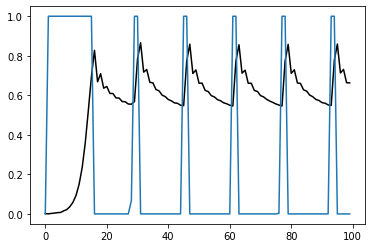

In [134]:
#plt.plot(alpha_hat_ar)
plt.plot(x_t_RNN, color='black')
#plt.plot(alpha_hat_ar)
plt.plot(s_ar)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


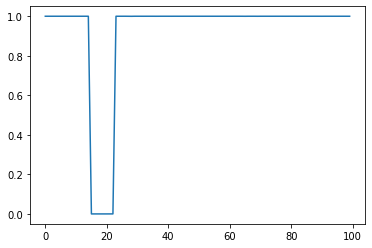

In [116]:
#plt.plot(np.heaviside(w_alpha*x_t_RNN + u_alpha + b_alpha,0.5))
plt.plot(sigmoid(1000*(w_alpha*x_t_RNN + u_alpha + b_alpha)))